In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

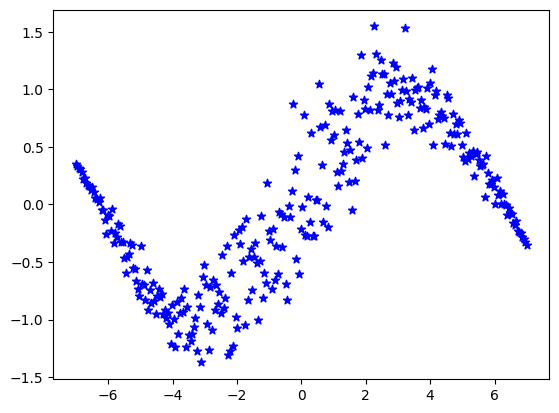

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

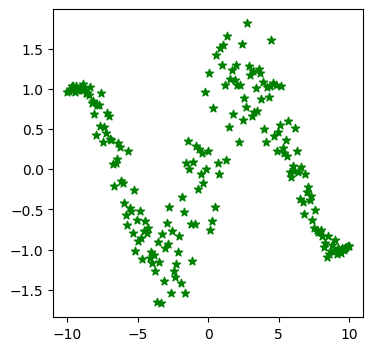

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [6]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mu = self.mu(h)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(h))
        return mu, var



In [8]:

sns.set(rc={'figure.figsize':(4, 4)})

def make_plot(model):
    # Get predictions
    mu, var = model(tensor_x_test)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()

In [9]:
net = SimpleNet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
net.train()
net.to(device)

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)

In [12]:
def MLE_snn():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


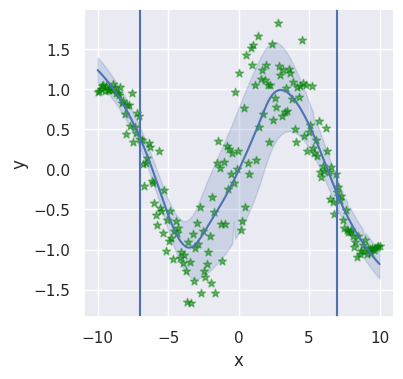

Epoch 149 | batch train loss: -1.026638150215149 | test loss: 0.09736263751983643
Epoch 149 |batch train mse:0.08719104528427124| test mse:0.14918870192307693


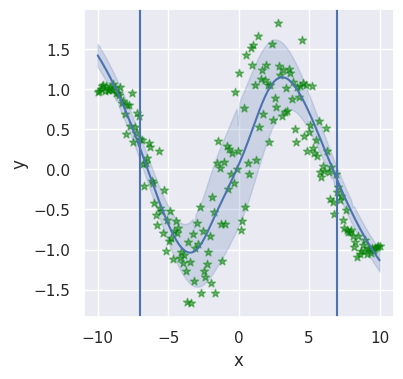

Epoch 149 | batch train loss: -1.3024379014968872 | test loss: 0.41897329917320836
Epoch 149 |batch train mse:0.04651883244514465| test mse:0.14944627078679892


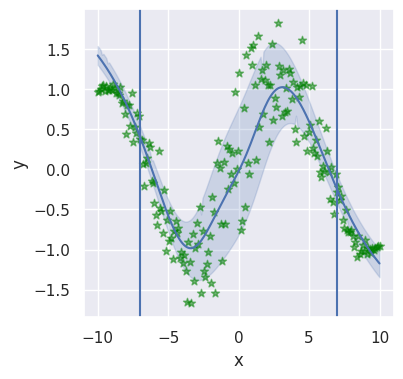

Epoch 149 | batch train loss: -0.6042596697807312 | test loss: 0.060028043790505484
Epoch 149 |batch train mse:0.13369692862033844| test mse:0.13911704203257194


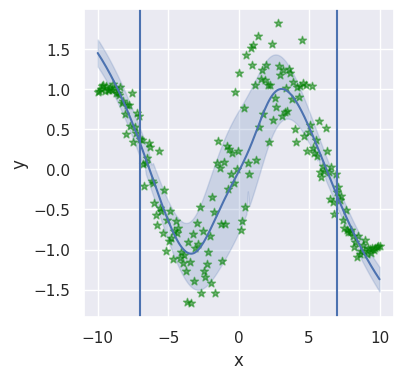

Epoch 149 | batch train loss: -1.216098666191101 | test loss: 0.17740393372682425
Epoch 149 |batch train mse:0.08563026040792465| test mse:0.1470487226660435


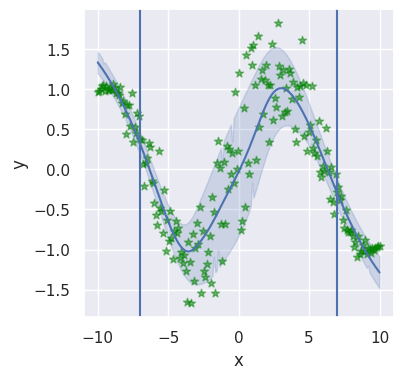

Epoch 149 | batch train loss: -1.4748188257217407 | test loss: 0.09920899340739617
Epoch 149 |batch train mse:0.03224017843604088| test mse:0.14274278311775282


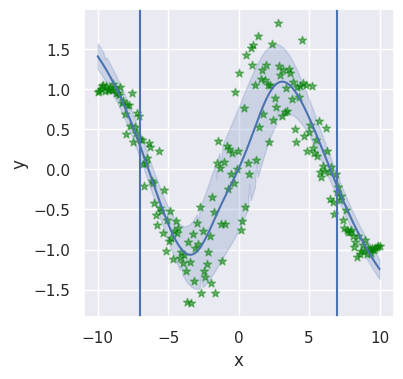

Epoch 149 | batch train loss: -1.1380667686462402 | test loss: 0.5497968792915344
Epoch 149 |batch train mse:0.05003173649311066| test mse:0.1515917846789727


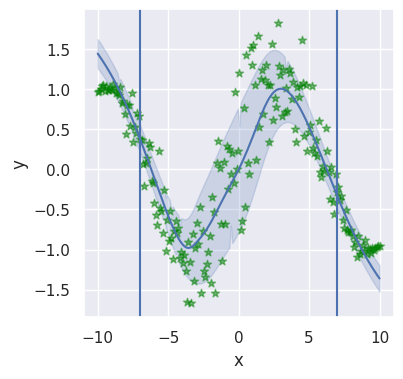

Epoch 149 | batch train loss: -1.1360206604003906 | test loss: 0.41686758456321865
Epoch 149 |batch train mse:0.10070937126874924| test mse:0.14475647503366837


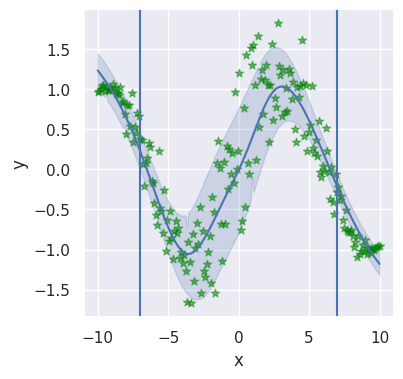

Epoch 149 | batch train loss: -0.6869382858276367 | test loss: 0.19642296204200158
Epoch 149 |batch train mse:0.09630053490400314| test mse:0.15157382247539666


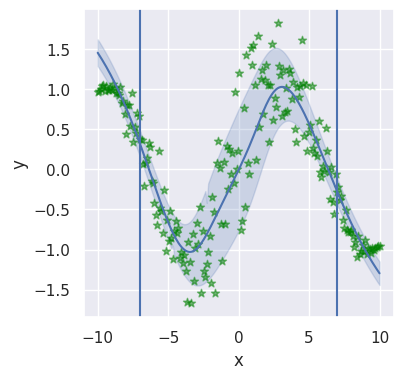

Epoch 149 | batch train loss: -1.2373007535934448 | test loss: 0.26201761026795095
Epoch 149 |batch train mse:0.0582050196826458| test mse:0.1416221186518669


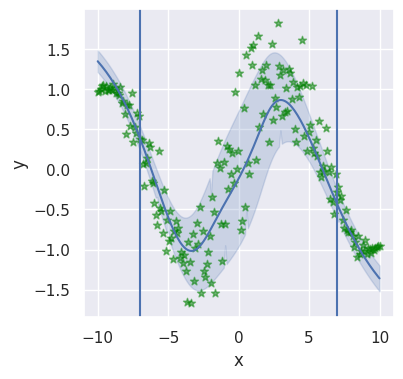

Epoch 149 | batch train loss: -1.230819821357727 | test loss: 0.16852601617574692
Epoch 149 |batch train mse:0.08294492214918137| test mse:0.14393134988271272


In [13]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

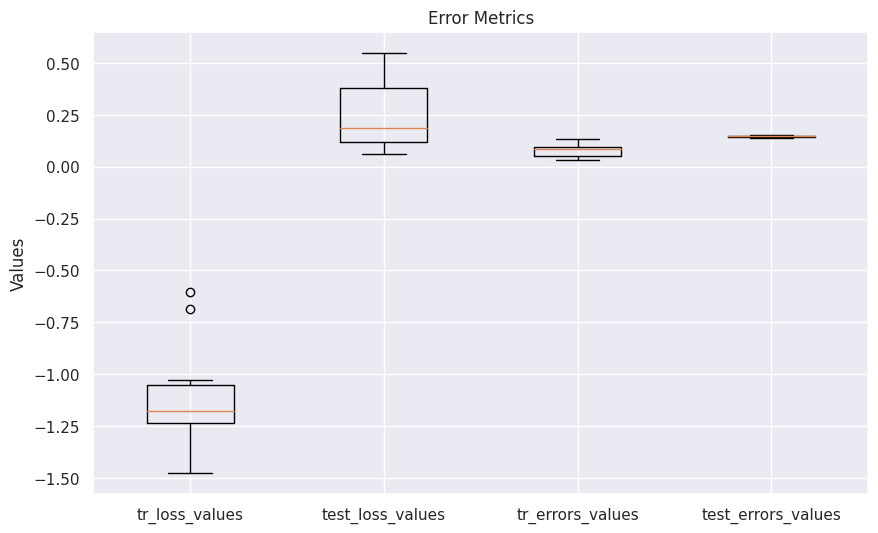

In [14]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [19]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.026638      0.097363                     0.087191   
2       -1.302438      0.418973                     0.046519   
3       -0.604260      0.060028                     0.133697   
4       -1.216099      0.177404                     0.085630   
5       -1.474819      0.099209                     0.032240   
6       -1.138067      0.549797                     0.050032   
7       -1.136021      0.416868                     0.100709   
8       -0.686938      0.196423                     0.096301   
9       -1.237301      0.262018                     0.058205   
10      -1.230820      0.168526                     0.082945   

    Mean Squared Testing Error  
1                     0.149189  
2                     0.149446  
3                     0.139117  
4                     0.147049  
5                     0.142743  
6                     0.151592  
7                     0.144756  
8                     0.151574 